In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime
import mplfinance as mpf
from functools import partial

In [2]:
stock_index = ff.read('一字板').index
up = ff.read('up').loc[stock_index,'20200102':].copy()
close = ff.read('close').loc[stock_index,'20200102':].copy()
high = ff.read('high').loc[stock_index,'20200102':].copy()
low = ff.read('low').loc[stock_index,'20200102':].copy()
pre_close = ff.read('pre_close').loc[stock_index,'20200102':].copy()
up_limit = pd.DataFrame(ff.read('up_limit').copy(),index = stock_index,columns = up.columns)* ff.filter0.loc[stock_index,'20200102':]

In [3]:
up_filter = (high == up_limit)
dict = {}
for i in up_filter.sum(axis = 1)[up_filter.sum(axis = 1)>0].index:
    stock = up_filter.loc[i,:]
    dict[i] = list(stock[stock == True].index)

In [4]:
def up_first(stock):
    first = []
    df = ff.read_min(stock)
    for time in dict[stock]:
        start_time = pd.to_datetime(time).strftime('%Y-%m-%d') + ' 09:31:00'
        end_time = pd.to_datetime(time).strftime('%Y-%m-%d') + ' 15:00:00'
        data = df.loc[start_time:end_time,:]
        daily_up_limit = data.loc[:,'high_limit']
        if ((data.loc[:,'close'] == daily_up_limit).sum()>0):
            first.append(1)
        else:
            first.append(0)
    return first
with Pool(24) as p:
    res_lst = list(tqdm(p.imap(up_first,dict.keys()),total = len(dict.keys())))
min_close_factor = pd.DataFrame(np.nan,index = up.index,columns = up.columns)
for i in range(len(res_lst)):
    for j in range(len(res_lst[i])):
        min_close_factor.loc[list(dict.keys())[i],list(dict.values())[i][j]] = res_lst[i][j]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4640/4640 [01:56<00:00, 39.97it/s]


In [26]:
# ff.save('分钟收盘价触板',min_close_factor.loc[:,'20200825':'20240305']).replace({0:np.nan})

In [13]:
ff.read('分钟收盘价触板')

,20200825,20200826,20200827,20200828,20200831,20200901,20200902,20200903,20200904,20200907,...,20240221,20240222,20240223,20240226,20240227,20240228,20240229,20240301,20240304,20240305
000001.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000002.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000004.SZ,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873703.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873706.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873726.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873806.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
ff.save('分钟收盘价触板',min_close_factor)

high == 涨停板
close == 涨停板
close == 涨停板 剔除开盘涨停

In [15]:
event = ff.read('分钟收盘价触板').copy()

In [12]:
def daily_K_line(event,n,open,close,high,low):
    # 日均事件K线
    T0open=event*open  # 以T0open作为基准
    pre_close = event * close.shift(axis = 1)
    data=pd.DataFrame(columns=['T'+str(j) for j in range(n)])
    for j in range(n):
        _open=(event*open.shift(-j,axis=1))/pre_close
        _close=(event*close.shift(-j,axis=1))/pre_close
        _low=(event*low.shift(-j,axis=1))/pre_close
        _high=(event*high.shift(-j,axis=1))/pre_close
        lst=[_open.mean().mean(),_close.mean().mean(),_low.mean().mean(),_high.mean().mean()]
        data['T'+str(j)]=lst
    data.index=['open','close','low','high']
    data=data.T
    data.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
    mpf.plot(data,type='candle',style='default')
    return data

In [13]:
stock_index = ff.read('一字板').index
time_index = ff.read('一字板').columns
open_ = (ff.read('open') * ff.read('post')).loc[stock_index,time_index].copy()
close_ = (ff.read('close')* ff.read('post')).loc[stock_index,time_index].copy()
high_ = (ff.read('high')* ff.read('post')).loc[stock_index,time_index].copy()
low_ = (ff.read('low')* ff.read('post')).loc[stock_index,time_index].copy()

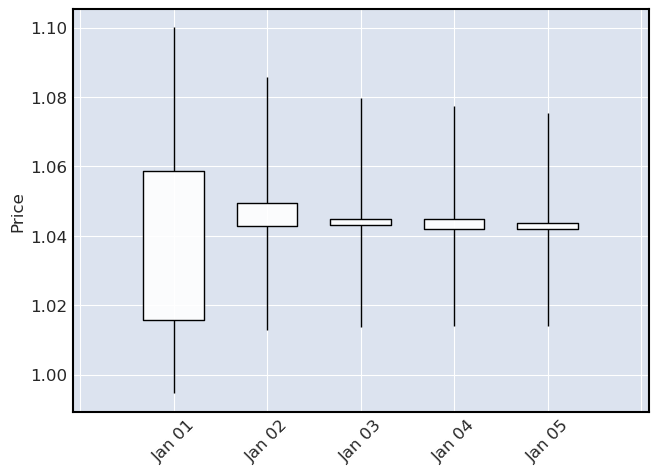

,open,close,low,high
2020-01-01,1.015625,1.058817,0.994584,1.100057
2020-01-02,1.042709,1.049470,1.012744,1.085741
2020-01-03,1.043063,1.044833,1.013819,1.079632
2020-01-04,1.042086,1.044976,1.013915,1.077371
2020-01-05,1.041909,1.043798,1.014088,1.075357


In [51]:
daily_K_line(event * ff.read('10cm') * ff.read('up').replace({1.0:np.nan,np.nan:1.0}),5,open_,close_,high_,low_)

分钟收盘价触板 + 开盘未涨停

In [17]:
event

,20200825,20200826,20200827,20200828,20200831,20200901,20200902,20200903,20200904,20200907,...,20240221,20240222,20240223,20240226,20240227,20240228,20240229,20240301,20240304,20240305
000001.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000002.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000004.SZ,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873703.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873706.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873726.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873806.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


分钟收盘价触板 + 开盘未涨停 + 尾盘未涨停


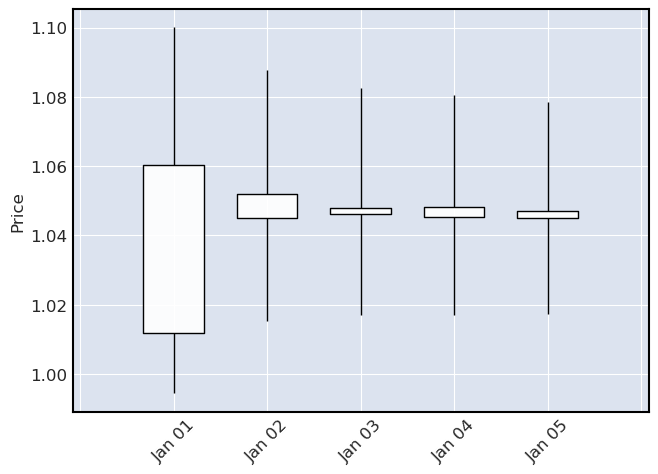

,open,close,low,high
2020-01-01,1.011801,1.060438,0.994391,1.100057
2020-01-02,1.045102,1.051996,1.015271,1.087829
2020-01-03,1.046059,1.047908,1.016916,1.082476
2020-01-04,1.045404,1.048201,1.017158,1.080646
2020-01-05,1.045176,1.047005,1.017229,1.078582


In [52]:
print('分钟收盘价触板 + 开盘未涨停 + 尾盘未涨停')
daily_K_line(event * (ff.read('open').loc[stock_index,'20200102':'20240305'].copy() != up_limit) * ff.read('10cm') * ff.read('up').replace({1.0:np.nan,np.nan:1.0}),5,open_,close_,high_,low_)

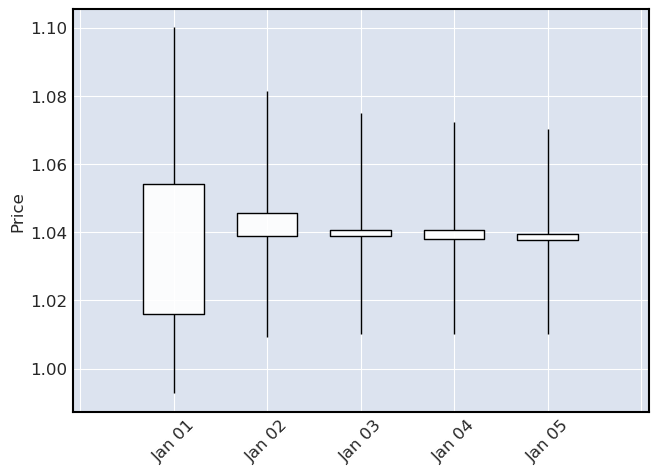

,open,close,low,high
2020-01-01,1.015877,1.054270,0.992728,1.100056
2020-01-02,1.038792,1.045502,1.009342,1.081354
2020-01-03,1.038990,1.040741,1.010162,1.074930
2020-01-04,1.037896,1.040541,1.010225,1.072444
2020-01-05,1.037613,1.039393,1.010253,1.070369


In [44]:
daily_K_line((high == up_limit).replace({False:np.nan,True:1.0}) * ff.read('10cm') * ff.read('up').replace({1.0:np.nan,np.nan:1.0}),5,open_,close_,high_,low_)

In [6]:
def up_time(stock):
    first = []
    df = ff.read_min(stock)
    for time in dict[stock]:
        start_time = pd.to_datetime(time).strftime('%Y-%m-%d') + ' 09:31:00'
        end_time = pd.to_datetime(time).strftime('%Y-%m-%d') + ' 15:00:00'
        data = df.loc[start_time:end_time,:]
        daily_up_limit = data.loc[:,'high_limit']
        if ((data.loc[:,'close'] == daily_up_limit).sum()>0):
            first.append((data.loc[:,'close'] == daily_up_limit).sum())
        else:
            first.append(0)
    return first
with Pool(24) as p:
    res_lst = list(tqdm(p.imap(up_time,dict.keys()),total = len(dict.keys())))
min_len_factor = pd.DataFrame(np.nan,index = up.index,columns = up.columns)
for i in range(len(res_lst)):
    for j in range(len(res_lst[i])):
        min_len_factor.loc[list(dict.keys())[i],list(dict.values())[i][j]] = res_lst[i][j]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4640/4640 [01:42<00:00, 45.17it/s]


In [15]:
ff.save('炸板股封板时间',(min_len_factor.loc[:,'20200825':'20240305']).replace({0:np.nan}))

In [22]:
min_len_factor.loc[:,'20200825'].dropna()

000881.SZ    189.0
000897.SZ    231.0
002327.SZ    209.0
002429.SZ    210.0
002534.SZ    240.0
002537.SZ    221.0
002677.SZ    234.0
002855.SZ    240.0
002861.SZ      3.0
002885.SZ    240.0
002903.SZ     90.0
300106.SZ    207.0
300116.SZ    218.0
300135.SZ      0.0
300152.SZ    109.0
300176.SZ    135.0
300269.SZ    213.0
300313.SZ    215.0
300368.SZ     22.0
300446.SZ    167.0
300592.SZ      1.0
600158.SH    239.0
600189.SH     12.0
600321.SH    227.0
600396.SH      5.0
600543.SH      1.0
600726.SH      0.0
600823.SH    145.0
600976.SH    198.0
603076.SH     16.0
603161.SH    186.0
603167.SH    144.0
603226.SH    234.0
603256.SH      0.0
603535.SH     17.0
603595.SH    240.0
603663.SH    148.0
603683.SH    218.0
603688.SH    197.0
603709.SH     22.0
603787.SH     60.0
603826.SH    156.0
603848.SH    189.0
Name: 20200825, dtype: float64

In [31]:
ff.read_min('300592.SZ').loc['2020-08-25 09:31:00':'2020-08-25 15:30:00',]

,open,close,low,high,volume,money,high_limit,low_limit,paused
2020-08-25 09:31:00,25.01,25.61,25.01,25.75,716700.0,18059114.0,28.73,19.15,0.0
2020-08-25 09:32:00,25.62,25.63,25.62,25.88,390000.0,10028110.0,28.73,19.15,0.0
2020-08-25 09:33:00,25.61,25.30,25.30,25.61,179900.0,4571750.0,28.73,19.15,0.0
2020-08-25 09:34:00,25.39,25.48,25.35,25.61,206700.0,5252818.0,28.73,19.15,0.0
2020-08-25 09:35:00,25.46,25.71,25.46,25.75,192400.0,4937752.0,28.73,19.15,0.0
...,...,...,...,...,...,...,...,...,...
2020-08-25 14:56:00,25.48,25.45,25.45,25.51,71700.0,1826386.0,28.73,19.15,0.0
2020-08-25 14:57:00,25.45,25.60,25.45,25.60,74700.0,1904233.0,28.73,19.15,0.0
2020-08-25 14:58:00,25.60,25.54,25.54,25.60,6100.0,156130.0,28.73,19.15,0.0
2020-08-25 14:59:00,25.54,25.54,25.54,25.54,0.0,0.0,28.73,19.15,0.0
